In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


import wrangle1 as w

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 300

In [2]:
df = w.get_explore_data()
df = w.get_contest_data(df)
train, validate, test = w.split_data(df)

In [3]:
train.head()

,region,elevation,lat,lon,startdate,potential_evap,precip,barometric_pressure,all_atmos_precip,relative_humidity,sea_level_press,mean_temp,height_10_mb,height_100_mb,height_500_mb,height_850_mb,zonal_wind_250mb,zonal_wind_925mb,long_wind_250mb,long_wind_925mb,elevation_range,region_bins
43062,BSh,1000.0,0.227273,0.433333,2016-06-26,510.23,40.14,90770.49,29.03,32.62,101230.49,29.044490,31377.44,16707.77,5928.46,1536.71,11.31,1.87,6.97,0.25,mid,NaN
310068,Csb,1000.0,0.772727,0.066667,2015-01-03,48.25,23.02,92339.65,10.83,87.90,102376.61,0.567343,30451.45,16246.90,5710.38,1531.84,17.52,-0.25,-5.08,3.51,mid,Temperate
279304,BSk,2000.0,0.681818,0.533333,2014-11-02,147.99,7.79,78176.80,5.80,68.56,102275.58,-2.242924,30778.83,16256.68,5633.01,1512.84,28.71,2.07,-12.16,0.47,high,Dry
210366,Dfc,3100.0,0.545455,0.566667,2016-03-23,54.39,22.12,75484.33,5.29,76.14,101656.83,-4.458912,30744.32,16199.63,5612.65,1478.02,17.52,1.71,-2.98,-0.82,high,Continental
90381,BSk,1500.0,0.318182,0.633333,2015-12-13,203.14,5.63,84225.98,6.59,62.36,101265.49,4.325158,30760.83,16276.61,5605.47,1445.74,37.08,4.18,9.06,0.61,mid,Dry


In [4]:
cont_vars = list(train.select_dtypes(include=np.number).columns)
cat_vars = list(train.select_dtypes(exclude=np.number).columns)

In [5]:
cont_vars.remove('elevation')
cont_vars.remove('lat')
cont_vars.remove('lon')

In [6]:
cont_vars.remove('mean_temp')

In [7]:
cont_vars

['potential_evap',
 'precip',
 'barometric_pressure',
 'all_atmos_precip',
 'relative_humidity',
 'sea_level_press',
 'height_10_mb',
 'height_100_mb',
 'height_500_mb',
 'height_850_mb',
 'zonal_wind_250mb',
 'zonal_wind_925mb',
 'long_wind_250mb',
 'long_wind_925mb']

In [8]:
train.columns

Index(['region', 'elevation', 'lat', 'lon', 'startdate', 'potential_evap',
       'precip', 'barometric_pressure', 'all_atmos_precip',
       'relative_humidity', 'sea_level_press', 'mean_temp', 'height_10_mb',
       'height_100_mb', 'height_500_mb', 'height_850_mb', 'zonal_wind_250mb',
       'zonal_wind_925mb', 'long_wind_250mb', 'long_wind_925mb',
       'elevation_range', 'region_bins'],
      dtype='object')

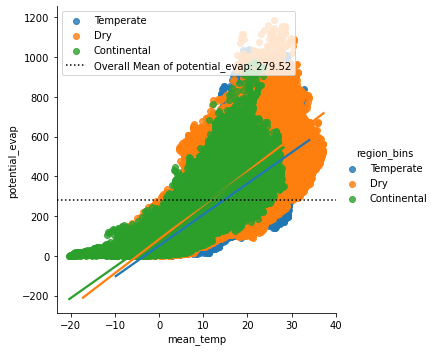

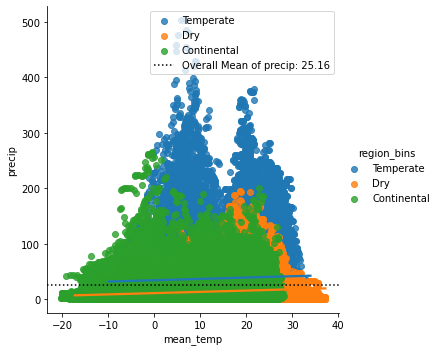

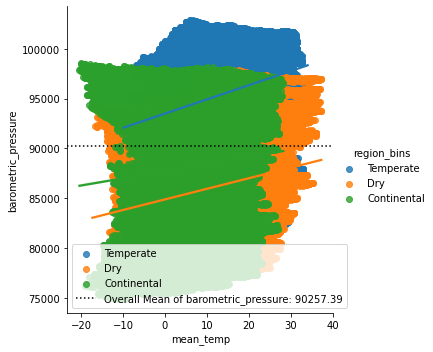

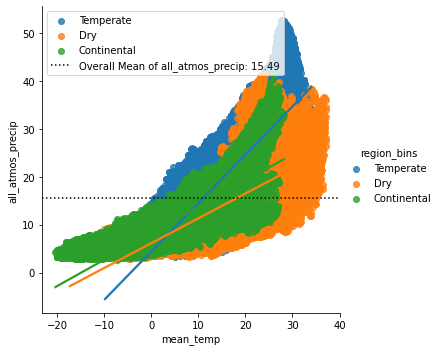

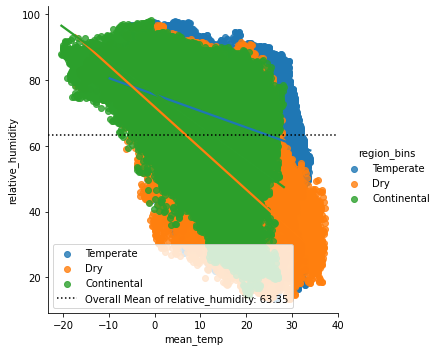

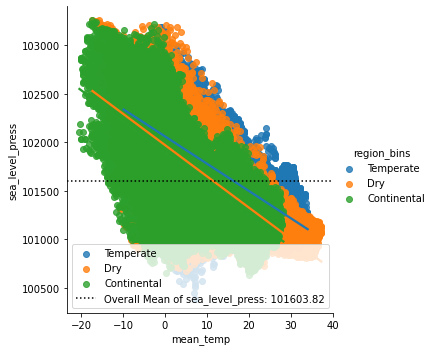

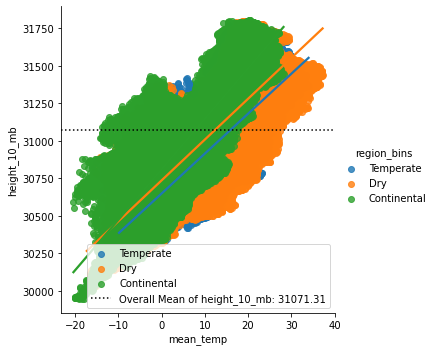

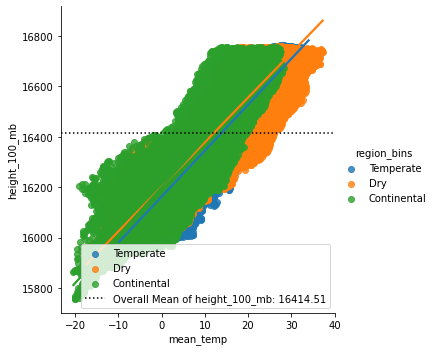

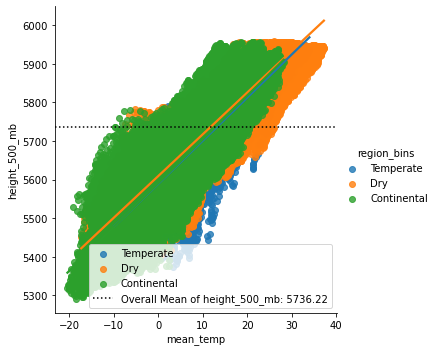

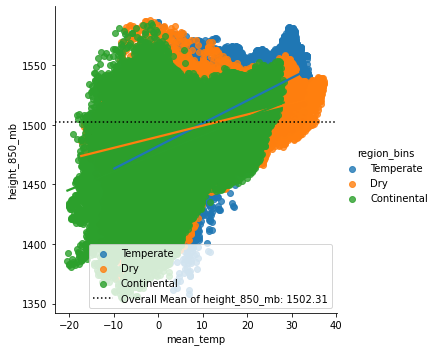

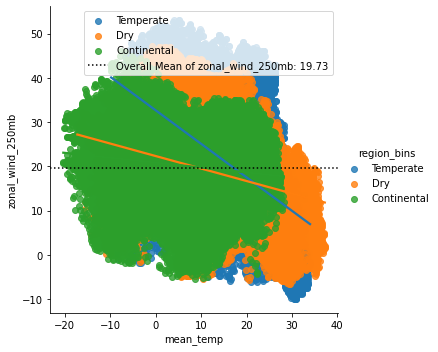

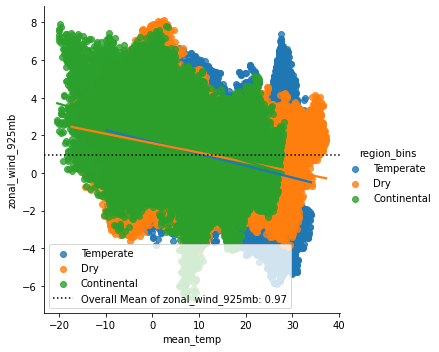

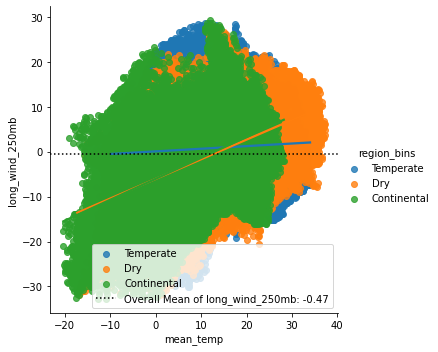

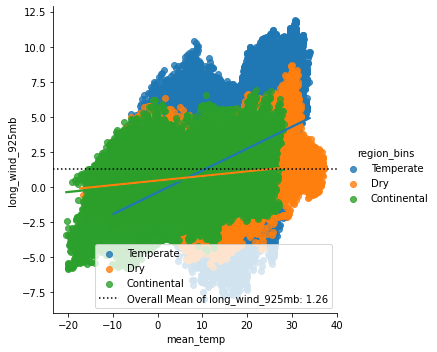

In [10]:
for col in cont_vars:
    sns.lmplot(x='mean_temp', y=col, data=train, hue='region_bins', pallett)
    rate = train[col].mean()
    plt.axhline(rate,  label = f'Overall Mean of {col}: {rate:.2f}', linestyle='dotted', color='black')
    plt.legend()
    plt.show()

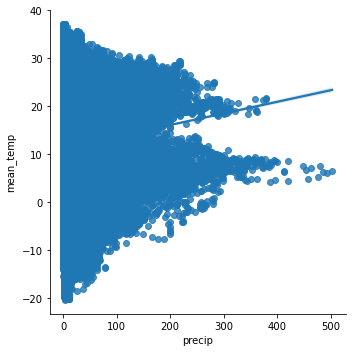

In [16]:
sns.lmplot(x='precip', y='mean_temp', data=train)

In [21]:
time_index = train.set_index('startdate').sort_index()

<AxesSubplot:>

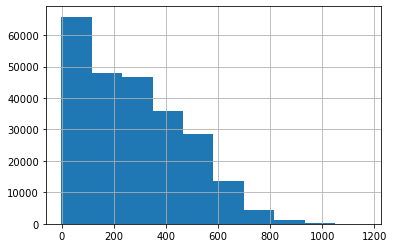

In [23]:
train['potential_evap'].hist()

In [3]:
import sklearn.preprocessing as pre

In [31]:
def create_region_bins(df):
    region_lists = [['BWh', 'BWk', 'Bsh', 'BSk'], ['Csa', 'Csb', 'Cfa', 'Cfa'], ['Dsb', 'Dsc', 'Dwa', 'Dwb', 'Dfa', 'Dfb', 'Dfc']]

    names =['Dry','Temperate','Continental']

    # create a df with mapping information
    maps = (pd.DataFrame({'region_bins': names, 'region': region_lists})
            .explode('region')
            .reset_index(drop=True))

    # join maps
    df = train.merge(maps, on='region', how='left')
    
    return df

In [5]:
region_lists = [['BWh', 'BWk', 'Bsh', 'BSk'], ['Csa', 'Csb', 'Cfa', 'Cfa'], ['Dsb', 'Dsc', 'Dwa', 'Dwb', 'Dfa', 'Dfb', 'Dfc']]

names =['B','C','D']

# create a df with mapping information
maps = (pd.DataFrame({'region_bins': names, 'region': region_lists})
        .explode('region')
        .reset_index(drop=True))

# join maps
validate = validate.merge(maps, on='region', how='left')

In [6]:
def create_elevation_bins(df):
    bins = [0, 500, 1000, 2000, 4000]
    names = ['bottom_low', 'top_low', 'mid', 'high']

    df['elevation_range'] = pd.cut(df['elevation'], bins, labels=names)
    
    return df

In [7]:
def scale_data(train, validate, test):
    '''
    Takes in train, validate, test and a list of features to scale
    and scales those features.
    Returns df with new columns with scaled data
    '''
    scale_features= list(train.select_dtypes(include=np.number).columns)
    
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    minmax = pre.MinMaxScaler()
    minmax.fit(train[scale_features])
    
    train_scaled[scale_features] = pd.DataFrame(minmax.transform(train[scale_features]),
                                                  columns=train[scale_features].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[scale_features] = pd.DataFrame(minmax.transform(validate[scale_features]),
                                               columns=validate[scale_features].columns.values).set_index([validate.index.values])
    
    test_scaled[scale_features] = pd.DataFrame(minmax.transform(test[scale_features]),
                                                 columns=test[scale_features].columns.values).set_index([test.index.values])
    
    return train_scaled, validate_scaled, test_scaled





In [8]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test)

In [24]:
drivers = list(train.columns)
drivers.remove('region')
drivers.remove('startdate')
drivers.remove('elevation')
drivers.remove('mean_temp')

In [25]:
X_train = train_scaled[drivers]
dummy_df_train = pd.get_dummies(X_train[['region_bins','elevation_range']], dummy_na=False, drop_first=[True, True])
X_train = pd.concat([X_train, dummy_df_train], axis=1).drop(columns=['region_bins','elevation_range'])
y_train = train['mean_temp']

In [26]:
X_validate = validate_scaled[drivers]
dummy_df_validate = pd.get_dummies(X_validate[['region_bins','elevation_range']], dummy_na=False, drop_first=[True, True])
X_validate = pd.concat([X_validate, dummy_df_validate], axis=1).drop(columns=['region_bins','elevation_range'])
y_validate = validate['mean_temp']

In [16]:
import model as m

In [27]:
m.regression_models(X_train, y_train, X_validate, y_validate)

,model,RMSE_train,r^2_train,RMSE_validate,r^2_validate
0,OLS Regressor,1.868533,0.964563,1.865077,0.964958
1,Lasso_alpha_1,9.925980,0.000000,9.963322,0.000000
2,Quadratic,1.427490,0.979318,1.426547,0.979499


In [28]:
m.baseline_models(y_train, y_validate)

,model,RMSE_train,RMSE_validate,Difference
0,mean_baseline,9.925980,9.963322,-0.037342
1,median_baseline,9.937875,9.974187,-0.036312


In [29]:
import sklearn.metrics as metric

In [30]:
metric.mean_squared_error(
            y_train,
            y_train.mean()) ** .5

TypeError: Expected sequence or array-like, got <class 'float'>